In [209]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import tqdm
import time
import copy
import pandas as pd
import seaborn as sns
from IPython.display import clear_output
from sklearn.utils import class_weight

from config_reader import Config
from read_data import read_data
from preproc_data import *
from label_data import label_data
from split_data import split_data
from detection import *
from pathlib import Path
from size_out import conv2d_size_out

cfg = Config()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [210]:
cyclone_events, data = read_data(path='../data')
# Consider renaming first variable
cyclone_events_data, data, metrics = preproc_data(cyclone_events, metrics=data)
labels, events = label_data(cyclone_events_data.ce2)
no_cyclone_data = cyclone_events_data.ce2[:, :, labels == 0]

train_data = no_cyclone_data
test_data = cyclone_events_data.ce2

train_data = torch.tensor(no_cyclone_data, dtype=torch.double)
test_data = torch.tensor(cyclone_events_data.ce2, dtype=torch.double)

In [211]:
desc = "Encoder-decoder that tries to catch anomalies."
filename = "Anomaly.ipynb"
network_name = filename.split('.')[0]
comment = ""

In [236]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.conv2d_1_enc = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=2)
        self.conv2d_2_enc = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=2)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2)
        #self.batch_norm = nn.BatchNorm2d()
        new_h = conv2d_size_out(conv2d_size_out(36, kernel_size=3, stride=2), kernel_size=3, stride=2)
        new_w = conv2d_size_out(conv2d_size_out(69, kernel_size=3, stride=2), kernel_size=3, stride=2)
        self.dense_enc = nn.Linear(in_features=new_h * new_w * 64, out_features=self.latent_dim)
        self.flatten = nn.Flatten()
    
    def forward(self, x):
        #print(f"Encoder input shape: {x.shape}")
        x = self.conv2d_1_enc(x)
        #print(f"Encoder after conv2d_1: {x.shape}")
        x = self.lrelu(x)
        #print(f"Encoder after lrelu: {x.shape}")
        #x = self.batch_norm(x)
        #print(f"Encoder after batch_norm: {x.shape}")
        x = self.conv2d_2_enc(x)
        #print(f"Encoder after conv2d_2: {x.shape}")
        x = self.lrelu(x)
        #x = self.batch_norm(x)
        #print(f"Encoder after batch_norm: {x.shape}")
        # [128, 64, 8, 16]
        self.vol_size = np.array(x.shape)
        x = self.flatten(x)
        #print(f"Encoder after flatten: {x.shape}")
        x = self.dense_enc(x)
        #print(f"Encoder after dense: {x.shape}")
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        new_h = conv2d_size_out(conv2d_size_out(36, kernel_size=3, stride=2), kernel_size=3, stride=2)
        new_w = conv2d_size_out(conv2d_size_out(69, kernel_size=3, stride=2), kernel_size=3, stride=2)
        self.dense_dec = nn.Linear(in_features=self.latent_dim, out_features=new_h * new_w * 64)
        self.convtranspose2d_1_dec = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(3, 3), stride=2, output_padding=(0, 1))
        self.convtranspose2d_3_dec = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=(3, 3), stride=2, output_padding=(1, 0))  
        self.lrelu = nn.LeakyReLU(negative_slope=0.2)
        #self.batch_norm = nn.BatchNorm2d()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #print(f"Decoder input size: {x.shape}")
        x = self.dense_dec(x)
        #print(f"Decoder after dense: {x.shape}")
        x = torch.reshape(x, (x.shape[0], 64, 8, 16))
        #print(f"Decoder after reshape: {x.shape}")
        x = self.convtranspose2d_1_dec(x)
        #print(f"Decoder after convtranspose2d_1: {x.shape}")
        x = self.lrelu(x)
        #x = self.batch_norm(x)
        #print(f"Decoder after batch_norm: {x.shape}")
        x = self.convtranspose2d_3_dec(x)
        #print(f"Decoder after convtranspose2d_3: {x.shape}")
        x = self.sigmoid(x)
        return x



In [237]:
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from show_loss import show_loss
from test import test
from get_test_stats import get_test_stats
from show_test_data import show_test_data
from sklearn import metrics
from parameters import Stats
from IPython.display import clear_output
from config_reader import Config

'''
Train the network on given data.

nn           - Network to train.
batch_size   - Batch size to apply to data.
num_epochs   - How many epochs to train for.
train_data   - Data to train on.
labels_train - Labels for train_data.
loss_func    - Loss function.
optimizer    - Optimizer for gradients.
draw         - Whether to display loss dynamics.
step_test    - Whether to test on test data after each epoch.
args         - test data and test labels.

It's not recommended to use 'draw' and 'step_test' at the same time.
'''
def train_epoch(encoder, decoder, batch_size, train_data, loss_func, optimizer, device):  
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []

    encoder.double()
    decoder.double()

    iters = int(train_data.shape[2] / batch_size)
    for i in tqdm(range(iters)): 
        # Move tensor to the proper device
        image_batch = train_data[:, :, i:i + batch_size]
        image_batch = image_batch.to(device)
        image_batch = torch.unsqueeze(image_batch, 0)
        image_batch = image_batch.reshape(image_batch.shape[-1], image_batch.shape[0], image_batch.shape[1], image_batch.shape[2])
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_func(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [238]:
### Testing function
def test_epoch(encoder, decoder, test_data, device, loss_func):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()

    encoder.double()
    decoder.double()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for i in tqdm(range(test_data.shape[2])):
            # Move tensor to the proper device
            image_batch = test_data[:, :, i].to(device)
            image_batch = torch.unsqueeze(image_batch, 0)
            image_batch = torch.unsqueeze(image_batch, 0)
            #print(image_batch.shape)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_func(conc_out, conc_label)
    return val_loss.data

In [252]:
def plot_ae_outputs(encoder, decoder, n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_data.numpy()
    t_idx = {i : np.where(targets==i) for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2, n, i + 1)
      img = test_data[t_idx[i]][0]
      img = torch.unsqueeze(img, 0)
      img = torch.unsqueeze(img, 0)
      print(img.shape)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  

In [249]:
num_epochs = 10
lr = 1e-4
batch_size = 128
latent_dim = 8
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder(latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optimizer = optim.Adam(params_to_optimize, lr=lr, weight_decay=lr/num_epochs)
criterion = nn.MSELoss()
encoder.to(device)
decoder.to(device)
print(f'Selected device: {device}')

Selected device: cpu


In [250]:
train_data.shape, test_data.shape

(torch.Size([36, 69, 104350]), torch.Size([36, 69, 113960]))

In [243]:
num_epochs = 10
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss = train_epoch(
      encoder=encoder,
      decoder=decoder,
      batch_size=batch_size,
      train_data=train_data,
      loss_func=criterion,
      optimizer=optimizer,
      device=device)
   
   val_loss = test_epoch(
      encoder=encoder,
      decoder=decoder,
      test_data=test_data,
      device=device,
      loss_func=criterion)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)

  0%|          | 0/815 [00:00<?, ?it/s]

	 partial train loss (single batch): 0.226884
	 partial train loss (single batch): 0.226577
	 partial train loss (single batch): 0.226281
	 partial train loss (single batch): 0.225989
	 partial train loss (single batch): 0.225691
	 partial train loss (single batch): 0.225391
	 partial train loss (single batch): 0.225087
	 partial train loss (single batch): 0.224774
	 partial train loss (single batch): 0.224448
	 partial train loss (single batch): 0.224111
	 partial train loss (single batch): 0.223756
	 partial train loss (single batch): 0.223378
	 partial train loss (single batch): 0.222973
	 partial train loss (single batch): 0.222535
	 partial train loss (single batch): 0.222069
	 partial train loss (single batch): 0.221566
	 partial train loss (single batch): 0.221022
	 partial train loss (single batch): 0.220442
	 partial train loss (single batch): 0.219824
	 partial train loss (single batch): 0.219171
	 partial train loss (single batch): 0.218469
	 partial train loss (single batch

  0%|          | 0/113960 [00:00<?, ?it/s]

torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
torch.Size([1, 1, 36, 69])
t

AttributeError: 'Tensor' object has no attribute 'targets'

<Figure size 1600x450 with 0 Axes>

torch.Size([1, 1, 1])


RuntimeError: Calculated padded input size per channel: (1 x 1). Kernel size: (3 x 3). Kernel size can't be greater than actual input size

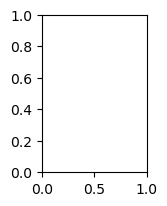

In [253]:
plot_ae_outputs(encoder,decoder,n=10)